In [5]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [7]:
# MongoDB connection
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["kafka_streaming"]
orders_collection = db["orders"]

# Load orders data
orders_cursor = orders_collection.find()
orders_df = pd.DataFrame(list(orders_cursor))

In [8]:
# Convert timestamp and prepare daily sales
orders_df['timestamp'] = pd.to_datetime(orders_df['timestamp'])
orders_df['date'] = orders_df['timestamp'].dt.date
daily_sales = orders_df.groupby('date').agg({'price': 'sum'}).reset_index()
daily_sales.rename(columns={'price': 'daily_total'}, inplace=True)

In [9]:
print(daily_sales.head())

         date  daily_total
0  1970-01-04       683.57
1  1970-01-06       809.19
2  1970-01-07       190.42
3  1970-01-08       716.81
4  1970-01-13       175.24


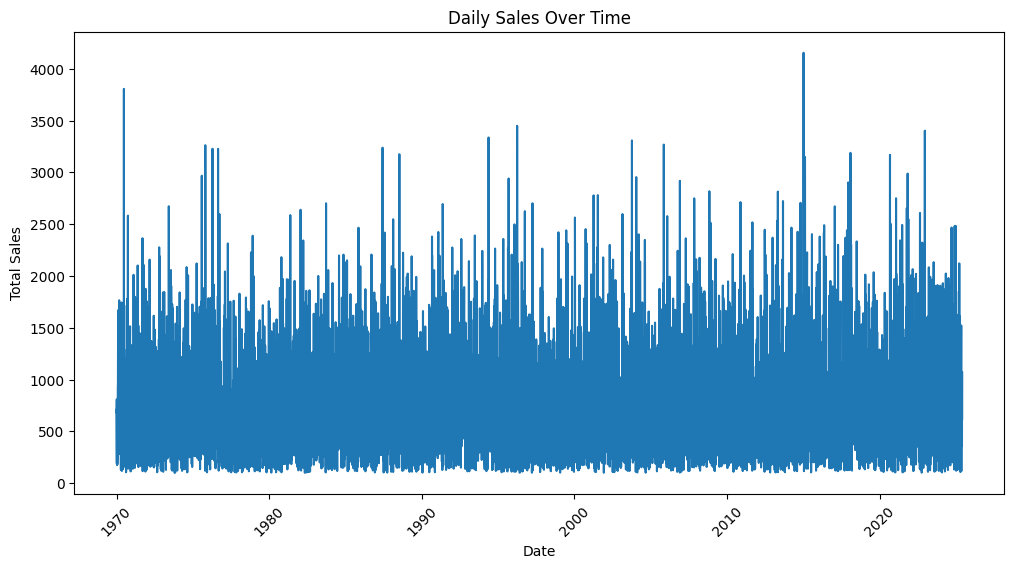

In [10]:
# Plot daily sales
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sales, x='date', y='daily_total')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


In [11]:
# Fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
daily_sales['anomaly'] = iso_forest.fit_predict(daily_sales[['daily_total']])

In [13]:
# Map anomaly labels
daily_sales['anomaly_label'] = daily_sales['anomaly'].map({1: 'Normal', -1: 'Anomaly'})

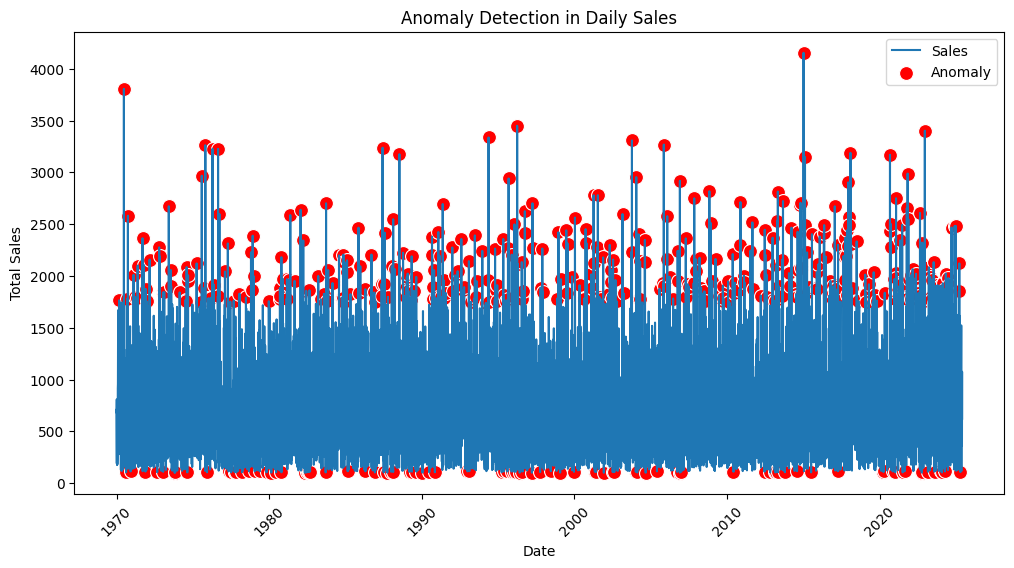

In [14]:
# Plot anomalies
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sales, x='date', y='daily_total', label='Sales')
sns.scatterplot(data=daily_sales[daily_sales['anomaly_label'] == 'Anomaly'], 
                x='date', y='daily_total', color='red', label='Anomaly', s=100)
plt.title('Anomaly Detection in Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [18]:
import datetime

save_to_mongo = True  # Set to False if you don't want to save results to MongoDB

if save_to_mongo:
    anomaly_collection = db["sales_anomalies"]
    records = daily_sales.to_dict('records')
    # Convert 'date' field to string for MongoDB compatibility
    for rec in records:
        if isinstance(rec['date'], (pd.Timestamp, )):
            rec['date'] = rec['date'].strftime('%Y-%m-%d')
        elif isinstance(rec['date'], (datetime.date, )):
            rec['date'] = rec['date'].isoformat()
    anomaly_collection.delete_many({})  # Clear old data
    anomaly_collection.insert_many(records)
    print("Anomaly results saved to MongoDB 'sales_anomalies' collection.")

print("✅ Anomaly detection complete!")

Anomaly results saved to MongoDB 'sales_anomalies' collection.
✅ Anomaly detection complete!
